In [20]:
import sqlalchemy as sa
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

database_management_sys = sa.create_engine('sqlite:///../Database-code/data/se/main.db')
connect_dbms_to_db = database_management_sys.connect()

In [82]:
supp_en_data = pd.read_sql('folk_theorem_experiment', connect_dbms_to_db)
supp_en_data.head(50)

,experiment_number,player_strategy_name,is_long_run_time,is_stochastic,memory_depth_of_strategy,prob_of_game_ending,payoff_matrix,num_of_repetitions,num_of_equilibria,nash_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise,warning_message
0,0,Inverse,False,True,Inf,0.001000,3. 0.99799549 1.00801804 1.,50,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
1,0,Defector,False,False,0,0.001000,3. 0.99799549 1.00801804 1.,50,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
2,1,Inverse,False,True,Inf,0.011081,3. 0.94865602 1.20537594 1.,50,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
3,1,Defector,False,False,0,0.011081,3. 0.94865602 1.20537594 1.,50,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
4,2,Inverse,False,True,Inf,0.021162,3. 0.95325314 1.18698744 1.,50,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
5,2,Defector,False,False,0,0.021162,3. 0.95325314 1.18698744 1.,50,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
6,3,Inverse,False,True,Inf,0.031242,3. 0.89941719 1.40233122 1.,50,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
7,3,Defector,False,False,0,0.031242,3. 0.89941719 1.40233122 1.,50,3.0,1. 0. 1. 0. ...,0.0,1.0,0.0,None
8,4,Inverse,False,True,Inf,0.041323,3. 0.85388804 1.58444782 1.,50,3.0,1. 0. 1. 0. 0...,0.0,1.0,0.0,None
9,4,Defector,False,False,0,0.041323,3. 0.85388804 1.58444782 1.,50,3.0,1. 0. 1. 0. 0...,0.0,1.0,0.0,None


In [81]:
(len(supp_en_data)/5)/100

84.0

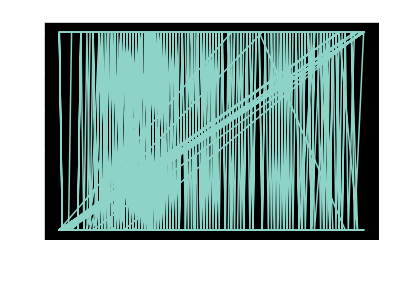

In [7]:
dbms = sa.create_engine('sqlite:///../Database-code/data/vertex_enumeration/main.db')
connect_to_db = database_management_sys.connect()

In [8]:
vertex_en_data = pd.read_sql('folk_theorem_experiment', connect_to_db)

In [9]:
vertex_en_data.head()

,experiment_number,player_strategy_name,is_long_run_time,is_stochastic,memory_depth_of_strategy,prob_of_game_ending,payoff_matrix,num_of_repetitions,num_of_equilibria,nash_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise,could_be_degenerate
0,1,Adaptive Pavlov 2011,False,False,Inf,0.0010,3. 0.98358155 1.0656738 1.,10,3.0,1. 0. 1. 0. 0. ...,0.0,1.0,0.0,False
1,1,Defector,False,False,0,0.0010,3. 0.98358155 1.0656738 1.,10,3.0,1. 0. 1. 0. 0. ...,0.0,1.0,0.0,False
2,2,Adaptive Pavlov 2011,False,False,Inf,0.2505,3. 0.7347619 2.06095238 1.,10,3.0,1. 0. 1. 0. 0....,0.0,1.0,0.0,False
3,2,Defector,False,False,0,0.2505,3. 0.7347619 2.06095238 1.,10,3.0,1. 0. 1. 0. 0....,0.0,1.0,0.0,False
4,3,Adaptive Pavlov 2011,False,False,Inf,0.5000,3. 0.3 3.8 1.,10,1.0,0. 1. 0. 1.,1.0,1.0,0.0,False
